In [1]:
setwd("/hpc/hub_oudenaarden/agiladi/data/tuft_release/")

In [2]:
set.seed(1111)

library(metacell)
source("release_code/metacell_functions.r")
library("Seurat")
library(flowCore)
library(flowWorkspace)
library(RColorBrewer)
library(GEOquery)
library(scales)
library(Hmisc)

Loading required package: reshape2
Warning message:
“package ‘reshape2’ was built under R version 3.6.3”Loading required package: plyr
Loading required package: plotrix
Warning message in .getGeneric(f, where, package):
“input string 'unable to find an inherited method for function ‘spillover’ for signature.*(flowSet|ncdfFlowSet)' cannot be translated to UTF-8, is it valid in 'ANSI_X3.4-1968'?”Warning message in .getGeneric(f, where, package):
“input string 'unable to find an inherited method for function ‘spillover’ for signature.*(flowSet|ncdfFlowSet)' cannot be translated to UTF-8, is it valid in 'ANSI_X3.4-1968'?”Warning message in .getGeneric(f, where, package):
“input string 'unable to find an inherited method for function ‘spillover’ for signature.*(flowSet|ncdfFlowSet)' cannot be translated to UTF-8, is it valid in 'ANSI_X3.4-1968'?”Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The

In [3]:
dir.create("release_figures")

outdir = "release_figures/primary_material/"
dir.create(outdir)

Warning message in dir.create("release_figures"):
“'release_figures' already exists”Warning message in dir.create(outdir):
“'release_figures/primary_material' already exists”

## Read Elmentaite's dataset

In [4]:
load("release_umi.tab/Full_obj_raw_counts_nosoupx_v2.Rda")

In [5]:
X = obj@assays$RNA
metadata = obj@meta.data

In [6]:
eec_pops = c('EC cells (TAC1+)', 'EC cells (NPW+)', 'EECs', 'M/X cells (MLN/GHRL+)',
             'L cells (PYY+)', 'I cells (CCK+)', 'D cells (SST+)', 'K cells (GIP+)',
             'N cells (NTS+)', 'β cells (INS+)')

anno = as.vector(metadata$Integrated_05)
anno[ anno %in% eec_pops] = "EEC"

In [7]:
good_pops = c("Stem cells", "TA", "Enterocyte", "Goblet cell", "Paneth", "EEC", "Tuft")
anno = factor(anno, levels = good_pops); names(anno) = rownames(metadata)

In [8]:
good_cells = names(anno)[ anno %in% good_pops &
                        metadata$Age_group == "Adult"]

In [9]:
table(anno[good_cells])


 Stem cells          TA  Enterocyte Goblet cell      Paneth         EEC 
       1022       43485        9649         699        2655         112 
       Tuft 
        569 

In [10]:
set.seed(1111)
k=500

# In some of the analyses we sample 500 cells per cell types
samp_cells = unlist(tapply(good_cells, anno[good_cells], function(x) sample(x, min(length(x), k))))

In [11]:
tuft_cells = intersect(good_cells, names(anno)[ anno == "Tuft"])

In [12]:
id = "Elmentaite"
scdb_init("saved_work/", force_reinit = T)
sc_2d = scdb_mc2d(id); sc_cl = scdb_mc(id); sc_mat = scdb_mat(id)

lfp = log2(sc_cl@mc_fp)
cells = names(sc_cl@mc)
cell_stats = sc_mat@cell_metadata[cells,]
colnames(cell_stats) = gsub(" ", ".", colnames(cell_stats))
colnames(cell_stats) = gsub("\\(|\\)", "_", colnames(cell_stats))

initializing scdb to saved_work/


In [13]:
umicount = as.matrix(read.delim("release_import/figure1_Elmentaite/umicount.txt", stringsAsFactors = F, row.names = 1))[,1]

In [14]:
good_cells = rownames(cell_stats)


In [15]:
data = X[,good_cells]
data_n = sweep(data,2,colSums(data),"/") * 1000

Loading required package: SeuratObject
Warning message:
“package ‘SeuratObject’ was built under R version 3.6.3”Registered S3 methods overwritten by 'SeuratObject':
  method                     from  
  $.JackStrawData            Seurat
  $.Seurat                   Seurat
  $.SeuratCommand            Seurat
  $<-.Seurat                 Seurat
  [.Assay                    Seurat
  [.DimReduc                 Seurat
  [.Seurat                   Seurat
  [.SeuratCommand            Seurat
  [[.Assay                   Seurat
  [[.DimReduc                Seurat
  [[.Seurat                  Seurat
  levels<-.Seurat            Seurat
  .DollarNames.JackStrawData Seurat
  .DollarNames.Seurat        Seurat
  .DollarNames.SeuratCommand Seurat
  as.list.SeuratCommand      Seurat
  as.logical.JackStrawData   Seurat
  dim.Assay                  Seurat
  dim.DimReduc               Seurat
  dim.Seurat                 Seurat
  dimnames.Assay             Seurat
  dimnames.DimReduc          Seurat
  dimna

In [16]:
# This function plot feature maps as in Extended Data Fig. 5a

plot_feature_maps = function(i, genes, nr = 2, nc = 3, rfac = 5) {
    cb = 1 / nc
    rb = 1 / nr
    locs = cbind(rep(seq_len(nc) - 1, nr), rep(rev(seq_len(nr)) - 1, each = nc))
    gene = genes[i]
    umis = sc_mat@mat[gene, names(sc_cl@mc)]
    umis_n = umis / umicount[ names(umis)]
    all_cells = names(sort(umis_n))
    vals = umis_n[all_cells]
    pos_vals = log(1 + 1 * vals[ vals > 0])
    pos_vals = pmin(pos_vals, quantile(pos_vals, 0.99))
    val_n = rep(1, length(all_cells)); names(val_n) = all_cells
    val_n[ names(pos_vals)] = round(100 * pos_vals / max(pos_vals)) + 1
    grad = colorRampPalette(c("gray90", "gray90", brewer.pal(3, "Reds")))(101)
    cell_ord = names(val_n) #sort(val_n))
    r = locs[i,2]; c = locs[i,1]
    par(fig = c(c / nc, c / nc + cb * 0.85, r / nr, r / nr + rb * 0.85), mar = rep(0.5,4), new = (i > 1))
    df = cbind(x = sc_2d@sc_x[ all_cells], y = sc_2d@sc_y[ all_cells], col = grad[ val_n[ all_cells]], 
               rx = round(sc_2d@sc_x[ all_cells] / rfac), ry = round(sc_2d@sc_y[ all_cells] / rfac))
    df = df[ !duplicated(df[, c("col", "rx", "ry")]),]
    dim(df)
    plot(df[,"x"], df[,"y"], pch = 20, cex = 0.7, col = df[,"col"], axes = F, xlab = "", ylab = "", main = gene)
    par (fig = c(c / nc + cb * 0.9, c / nc + cb * 1, r / nr + rb * 0.3, r / nr + rb * 0.6), new=T)
    ax = seq(0, max(pos_vals), length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax, c(0,1)), labels = round(quantile(ax, c(0,1)),3), las = 2)
}


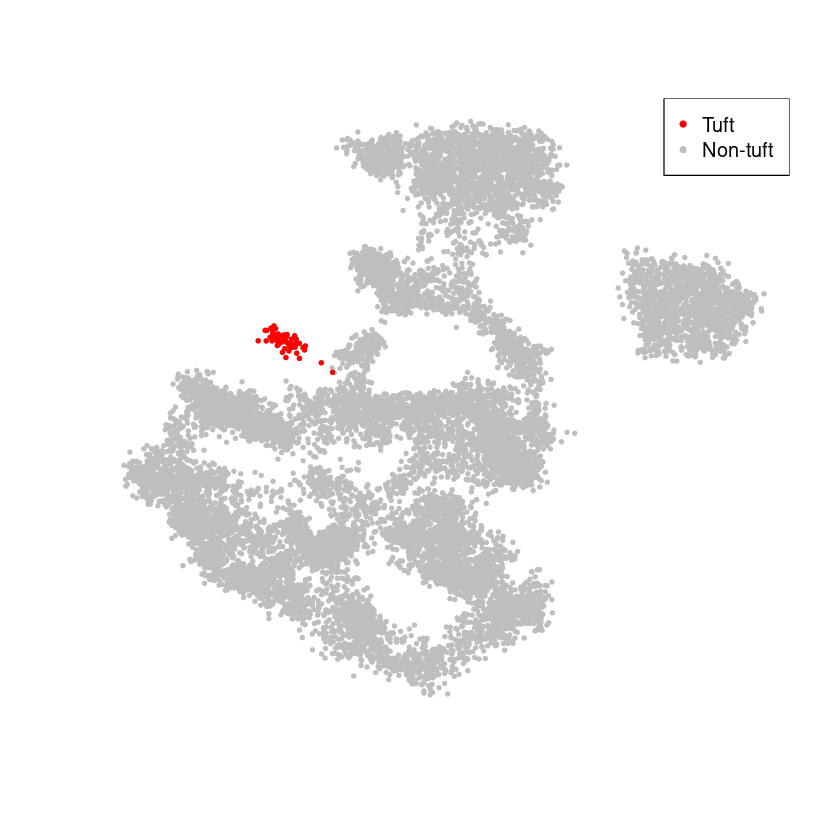

In [17]:
tuft_mc = colnames(lfp)[ lfp["AVIL",] > 1]
tuft_mc_cells = names(sc_cl@mc)[ sc_cl@mc %in% tuft_mc]

# Identify tuft cells
plot(sc_2d@sc_x, sc_2d@sc_y, pch = 20, col = "gray",axes = F, xlab = "", ylab = "", cex = 0.7)
points(sc_2d@sc_x[ tuft_mc_cells], sc_2d@sc_y[ tuft_mc_cells], pch = 20, col = "red", cex = 0.7)
legend("topright", c("Tuft", "Non-tuft"), pch = 20, col = c("red", "gray"))

png 
  2

png 
  2

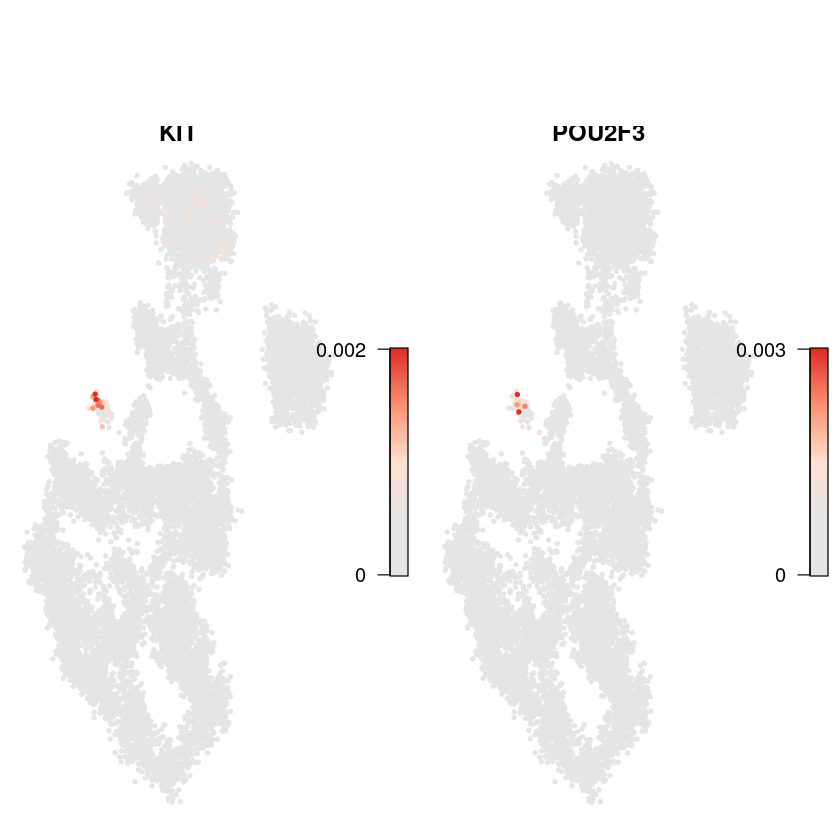

In [18]:
genes = c("KIT", "POU2F3")
pdf(paste0(outdir, "/ExtFig3a.pdf"), height=5, width=5, useDingbats=F)
plot_feature_maps(1, "KIT", rfac = 1, nr=1, nc = 1)
dev.off()

pdf(paste0(outdir, "/ExtFig5b_bottom.pdf"), height=5, width=5, useDingbats=F)
plot_feature_maps(1, "POU2F3", rfac = 1, nr=1, nc = 1)
dev.off()

invisible(sapply(seq_along(genes), plot_feature_maps, genes, rfac = 1, nr=1, nc = 2))

png 
  2

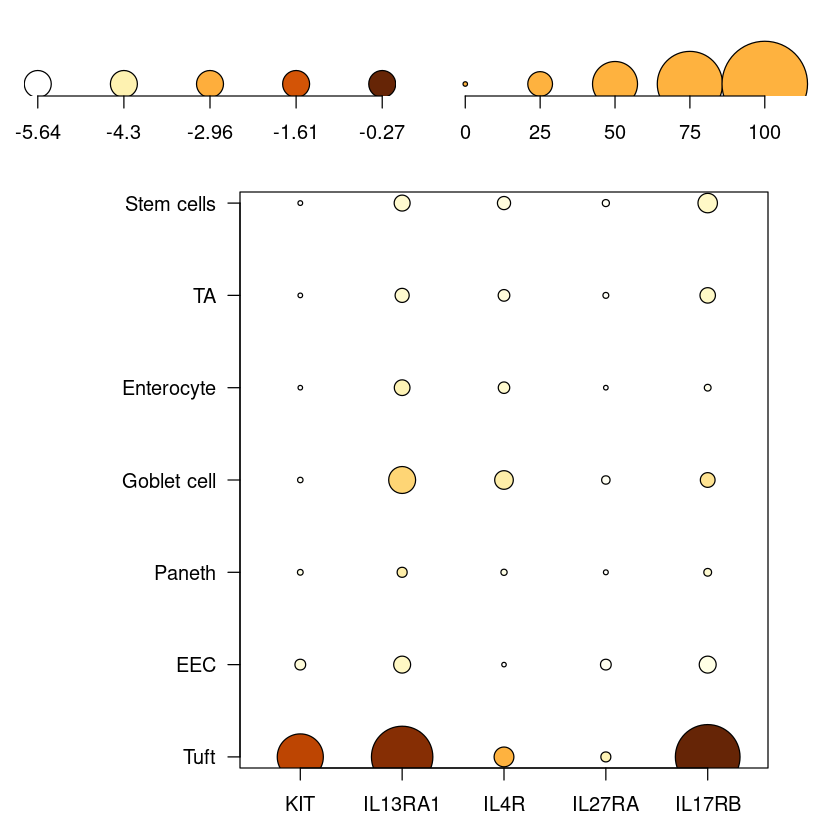

png 
  2

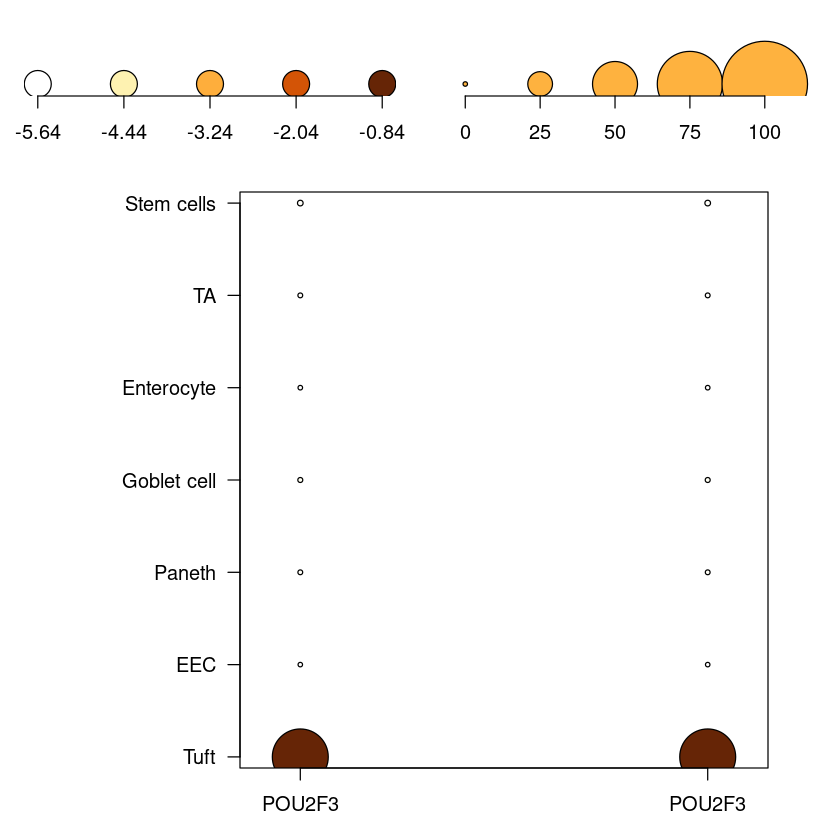

png 
  2

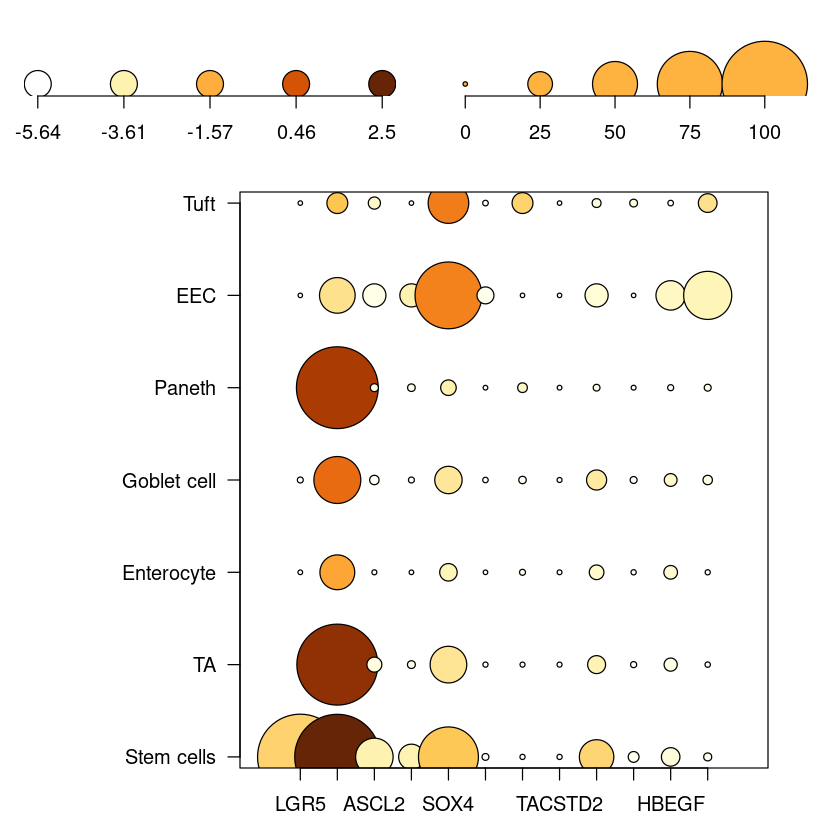

In [19]:
genes = c("KIT", "IL13RA1", "IL4R", "IL27RA", "IL17RB")

m = t(apply(data_n[genes, good_cells], 1, tapply, anno[ good_cells], mean))
IM = log2(m[, rev(colnames(m))] + 0.02)
exp_freq = t(apply(data[genes, good_cells] > 0, 1, tapply, anno[ good_cells], mean)) * 100
exp_freq = exp_freq[ ,colnames(IM)]

grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)

p = function() {
    par(mar = c(3,10,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}

p()
pdf(paste0(outdir, "/ExtFig2e.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

genes = c("POU2F3", "POU2F3")
m = t(apply(data_n[genes, good_cells], 1, tapply, anno[ good_cells], mean))
IM = log2(m[, rev(colnames(m))] + 0.02)
exp_freq = t(apply(data[genes, good_cells] > 0, 1, tapply, anno[ good_cells], mean)) * 100
exp_freq = exp_freq[ ,colnames(IM)]

grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)

p = function() {
    par(mar = c(3,10,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}

p()
pdf(paste0(outdir, "/ExtFig5b_top.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

genes = union(read.table("release_import/for_figures/stem_genes.txt", stringsAsFactors = F)[[1]],
              c("MEX3A", "ANXA1", "TACSTD2", "PROX1"))

m = t(apply(data_n[genes, good_cells], 1, tapply, anno[ good_cells], mean))
IM = log2(m + 0.02)
exp_freq = t(apply(data[genes, ] > 0, 1, tapply, anno[ colnames(data_n)], mean)) * 100
exp_freq = exp_freq[ ,colnames(m)]

p()
pdf(paste0(outdir, "/ExtFig8b.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()


png 
  2

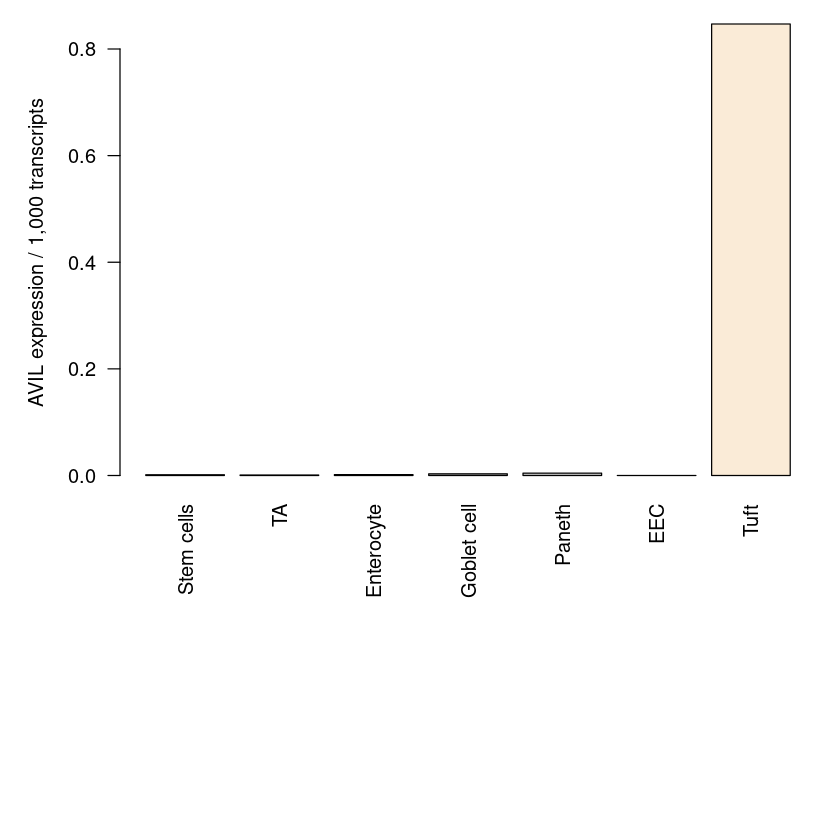

In [20]:
gene = "AVIL"
m = tapply(data_n[gene, good_cells], anno[ good_cells], mean)

p = function() {
    par(mar = c(15,5,1,1))
    barplot(m,las=2, ylab = "AVIL expression / 1,000 transcripts", col = ifelse(names(m) == "Tuft", "antiquewhite", "gray80"))    
}

p()
pdf(paste0(outdir, "/Fig1a.pdf"), useDingbats = F)
p()
dev.off()

png 
  2

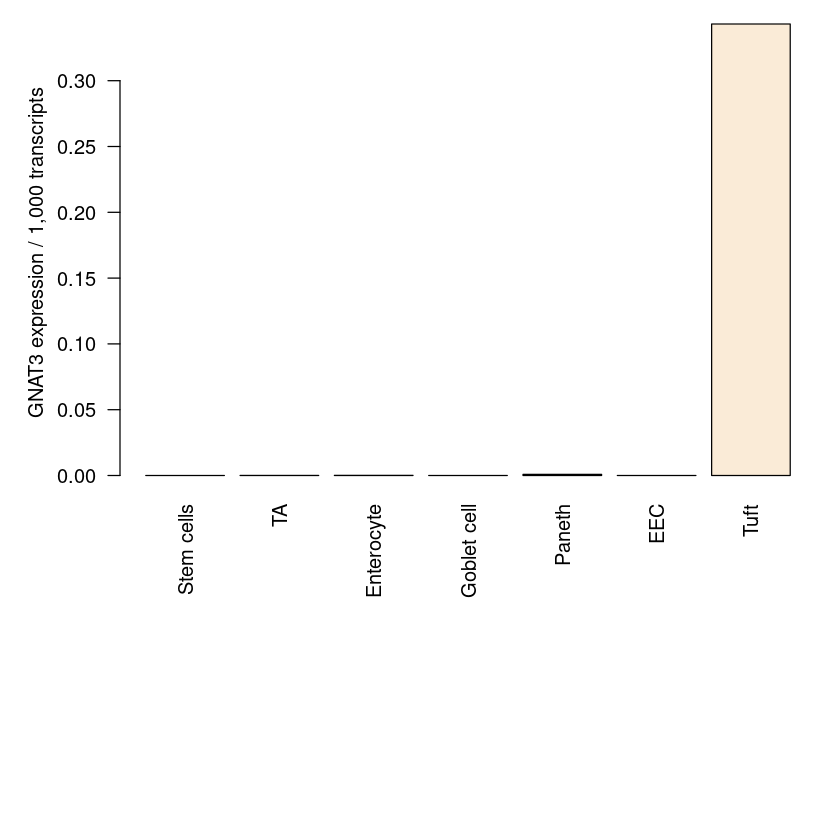

In [21]:
gene = "GNAT3"
m = tapply(data_n[gene, good_cells], anno[ good_cells], mean)

p = function() {
    par(mar = c(15,5,1,1))
    barplot(m,las=2, ylab = "GNAT3 expression / 1,000 transcripts", col = ifelse(names(m) == "Tuft", "antiquewhite", "gray80"))    
}

p()
pdf(paste0(outdir, "/ExtFig1k.pdf"), useDingbats = F)
p()
dev.off()

In [22]:
l = names(table(anno[ good_cells]))

In [23]:
genes = c("LGR5", "OLFM4", "APOA1", "APOB", "ALDOB", "ZG16", "MUC2", "FCGBP",
         "DEFA6", "DEFA5", "REG3A", "CHGB", "CHGA", "LCN15", "AVIL", "KIT", "POU2F3")
gene_anno = c(rep("Stem cells", 2), rep(l[-(1:2)], each = 3)); 
gene_anno = factor(gene_anno, levels = unique(gene_anno));
names(gene_anno) = genes

In [24]:
set.seed(1111)
X = obj@assays$RNA
ds = .downsamp(X[, samp_cells], 1000)
grad = colorRampPalette(c("blue", "white", "red"))(1000)

C = cor(t(log(1 + ds[genes,]))); diag(C) = NA

zlim: -0.95756952690001<>0.95756952690001
zlim: -0.95756952690001<>0.95756952690001


png 
  2

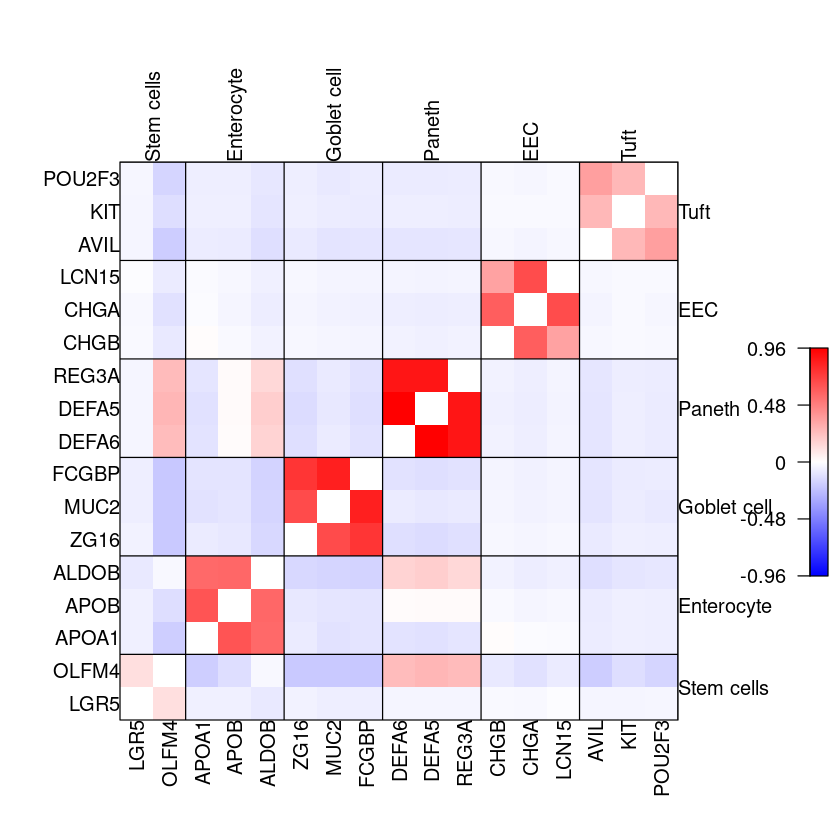

In [25]:
p = function() {
    par(fig=c(0,0.95,0,0.95), mar = c(5,5,5,5))
    image.2(C, b=T, hct = gene_anno, vct = gene_anno); box()
    par(fig=c(0.95,1,0.3,0.6), new=T, mar = rep(0.5,4))
    zlim = max(abs(C), na.rm = T)
    ax = seq(-zlim, zlim, length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax), labels = round(quantile(ax),2), las = 2)
}

p()
pdf(paste0(outdir, "/ExtFig5f.pdf"), useDingbats = F)
p()
dev.off()

## Analyze primary sort-seq data


In [26]:
scdb_init("saved_work", force=T)

sc_mat = scdb_mat("tuft_all")
sc_mat@ncells

cell_stats = sc_mat@cell_metadata
head(cell_stats)

initializing scdb to saved_work


[1] 3067

,amp_batch_id,cell_barcode,umicount,mt_count,coord,source,type,gating,treatment,age,clover
HUB.JO.s037_AAACAGGC,HUB.JO.s037,AAACAGGC,7296,1280,H18,Ileum,organoid,AVIL-Clover+,no_cyto,adult,AVIL
HUB.JO.s037_AAAGCGGA,HUB.JO.s037,AAAGCGGA,3461,626,P12,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AAAGGCTG,HUB.JO.s037,AAAGGCTG,4062,1019,O10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACACGCA,HUB.JO.s037,AACACGCA,8352,1471,L20,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACATGGG,HUB.JO.s037,AACATGGG,4986,692,P10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACCCAAC,HUB.JO.s037,AACCCAAC,8453,1449,O15,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL


In [27]:
bad_genes = grep("^MT-|^IG[H,L]|^ERCC", sc_mat@genes, v=T)
good_genes = setdiff(sc_mat@genes, bad_genes)

In [28]:
primary_cells = rownames(cell_stats)[ cell_stats$type == "tissue" & 
                    cell_stats$umicount > 500 &
                    cell_stats$mt_count / cell_stats$umicount < 0.4]

In [29]:
comb = paste0(cell_stats[ primary_cells, "source"], "@", cell_stats[ primary_cells, "age"], "@", cell_stats[ primary_cells, "gating"])
names(comb) = primary_cells

In [30]:
primary_umis = read_large_umis("tuft_all", cells = primary_cells)
primary_umis = primary_umis[ good_genes,]
primary_n = sweep(primary_umis, 2, colSums(primary_umis), "/") * 1000
primary_foc = log(1 + 7 * primary_n)

In [31]:
tuft_genes = read.delim("release_import/for_figures/organoids_tuft_genes.txt", stringsAsFactors = F, row.names=1)


In [32]:
# Score each cell for expression of the tuft cell core signature

core_genes = rownames(tuft_genes)[tuft_genes$anno == "Core"]
score = colSums(primary_foc[ core_genes,])

In [33]:
tuft4_genes = rownames(tuft_genes)[tuft_genes$anno == "Tuft-4"]
score4 = colSums(primary_foc[ tuft4_genes,])

tuft3_genes = rownames(tuft_genes)[tuft_genes$anno == "Tuft-3"]
score3 = colSums(primary_foc[ tuft3_genes,])


In [34]:
l = c('Colon@adult@CD117+', 'Ileum@adult@CD117+')
good_cells = names(comb)[ comb %in% l]

In [35]:
cell_anno = ifelse(score3 > 22, "Tuft-3", "None"); names(cell_anno) = names(score3)

In [36]:
comb2 = paste0(comb[ good_cells],"@", cell_anno[good_cells]); names(comb2) = good_cells

In [37]:
m = t(apply(primary_n[, good_cells], 1, tapply, comb2[ good_cells], mean))

In [38]:
reg = 0.04
z2tuft = log2((reg + m[,"Ileum@adult@CD117+@Tuft-3"]) / (reg + m[,"Ileum@adult@CD117+@None"]))

In [39]:
diff_genes = scr_chi_square_diff_genes(primary_umis, 
            g1 = names(which(comb2[ good_cells] == "Ileum@adult@CD117+@Tuft-3")), 
            g2 = names(which(comb2[ good_cells] == "Ileum@adult@CD117+@None")), pval = 1e-3, fdr = T)

tuft3_diff = intersect(diff_genes, tuft3_genes)

png 
  2

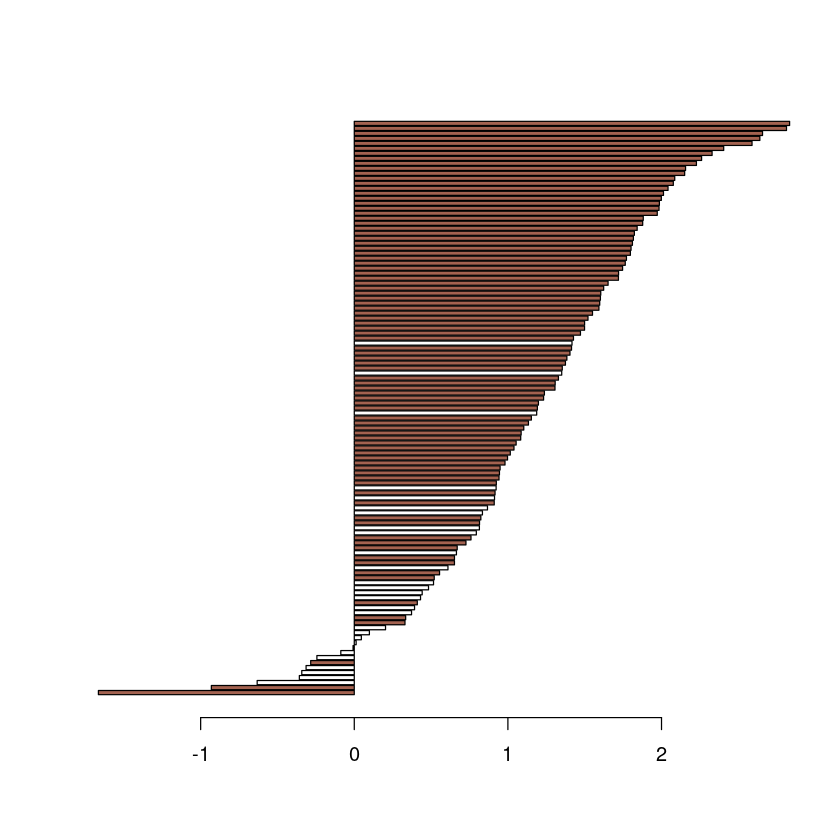

In [40]:
cc_col = "#a36250"

x = sort(z2tuft[ tuft3_genes])
p = function() {
    barplot(x, horiz = T, 
            col = ifelse(names(x) %in% tuft3_diff, cc_col, "white"), 
            names.arg = rep("", length(tuft3_genes)))    
}

p()
pdf(paste0(outdir, "/ExtFig4j.pdf"), height=12, width=8)
p()
dev.off()

In [41]:
cc_genes = setdiff(tuft3_genes, c("MUC2", "ITLN1", "TK1", "PIGR", "H4C3"))
cc_disp_genes = union(names(head(sort(z2tuft[ cc_genes], T), 20)), c("PCNA", "UBE2C"))


In [42]:
core_genes = c("AVIL", "POU2F3", "KIT")#, "ALOX5AP", "BMX", "SH2D6")
disp_genes = unique(c(core_genes, cc_disp_genes))

hct = factor(c(rep("Core", length(core_genes)), 
        rep("CC", length(cc_disp_genes))),
        levels = c("Core", "CC")); 
names(hct) = disp_genes

In [43]:
tissue = factor(paste0(cell_stats[ good_cells, "source"], "-",
                      cell_stats[ good_cells, "age"])); names(tissue) = good_cells



In [44]:
IM2 = as.matrix(log(1 + 7 * primary_umis[ disp_genes, good_cells]))

vct = paste0(comb[ colnames(IM2)], "@", cell_anno[ colnames(IM2)]); names(vct) = colnames(IM2)

IM2 = IM2[,order(score3[ colnames(IM2)])]
IM2 = IM2[,order(vct[ colnames(IM2)])]
IM2 = IM2[ order(hct[ rownames(IM2)], rowSums(primary_umis[ rownames(IM2),])),]

In [45]:
max_row = t(apply(IM2, 1, tapply, comb[ colnames(IM2)], quantile, 0.99))
IM3 = pmin((0 + IM2) / (0 + max_row[, comb[ colnames(IM2)]]), 1)

zlim: 0<>1
zlim: 0<>1


png 
  2

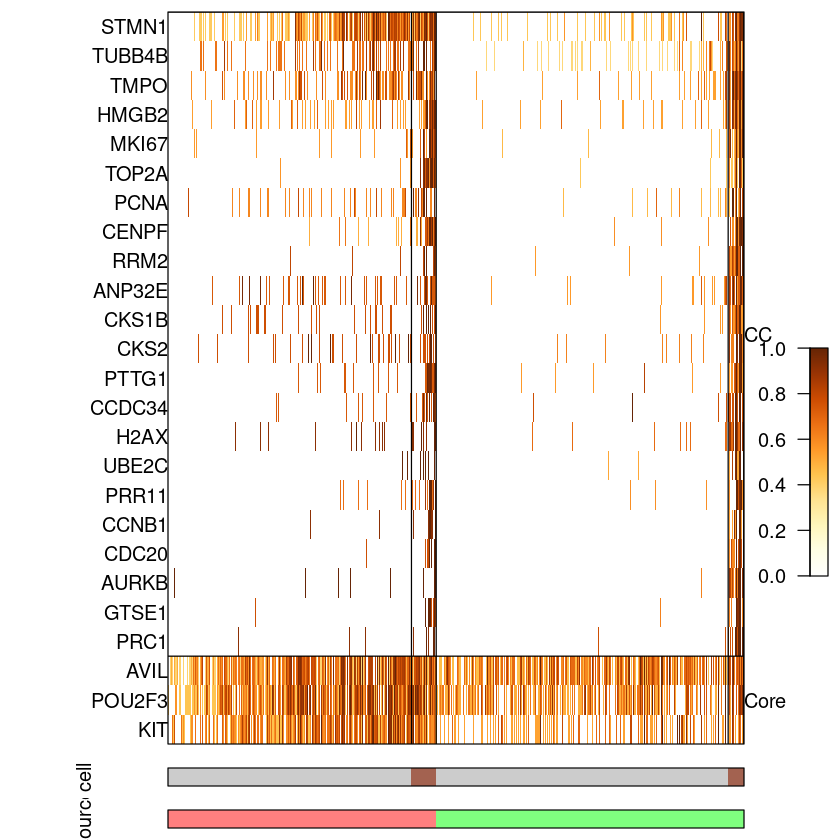

In [46]:

grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)

p = function() { 
    par(mar = c(0.5,7,0.5,0.5), fig = c(0,0.9,0.1,1))
    image.2(IM3, col = grad, annotate = "rows",
        vct = vct[ colnames(IM2)], hct = hct[ rownames(IM3)])
    box()
    par(mar = c(0.5,0.5,0.5,0.5), fig = c(0.95,1,0.3,0.6), new = T)
    image(y = seq(min(IM3), max(IM3), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2); box()
    par(mar = c(0.5,7,0.5,0.5), fig = c(0,0.9,0.05,0.1), new = T)
    image(matrix(seq_len(ncol(IM3))), axes = F, ylab = "cell", las = 2,
          col = c("gray80", cc_col)[ as.numeric(factor(cell_anno[ colnames(IM3)]))]); box()

    par(mar = c(0.5,7,0.5,0.5), fig = c(0,0.9,0,0.05), new = T)
    image(matrix(seq_len(ncol(IM3))), axes = F, ylab = "source",
          col = rainbow(3, alpha = 0.5)[ as.numeric(tissue[ colnames(IM3)])]); box()
}

p()
pdf(paste0(outdir, "/ExtFig4i.pdf"), height=12, width=8)
p()
dev.off()


In [47]:
no_cc = names(which(cell_anno != "Tuft-3"))
l = c('Colon@adult@CD117+', 'Ileum@adult@CD117+')#, 'Ileum@fetal@CD117+')
good_cells = intersect(no_cc, names(comb)[ comb %in% l])

In [48]:
us = primary_umis[, good_cells]
us = us[ rowSums(us) > 0,]


In [49]:
diff_genes = rev(c("PHGR1", "TNFSF10", "VIPR1", "DNAL1", "MGLL",
              "TRAK1", "PAPSS2", "CHP1", "MGST3", "CDHR2"))
core_genes = rev(c("AVIL", "KIT", "POU2F3"))
disp_genes = unique(c(core_genes, diff_genes))


In [50]:
IM2 = as.matrix(primary_foc[ disp_genes, good_cells])

hct = factor(c(rep("Core", length(core_genes)), 
        rep("Activation", length(diff_genes))), levels = c("Core", "Activation")); names(hct) = disp_genes
vct = paste0(comb[ colnames(IM2)], "@", cell_anno[ colnames(IM2)]); names(vct) = colnames(IM2)

IM2 = IM2[,order(score4[ colnames(IM2)])]
IM2 = IM2[,order(vct[ colnames(IM2)])]
IM2 = IM2[ order(hct[ rownames(IM2)]),]#, gene_rank),]
    
max_row = t(apply(IM2, 1, tapply, vct[ colnames(IM2)], quantile, 0.99))
IM3 = pmin((0 + IM2) / (0 + max_row[, vct[ colnames(IM2)]]), 1)

zlim: 0<>1
zlim: 0<>1


png 
  2

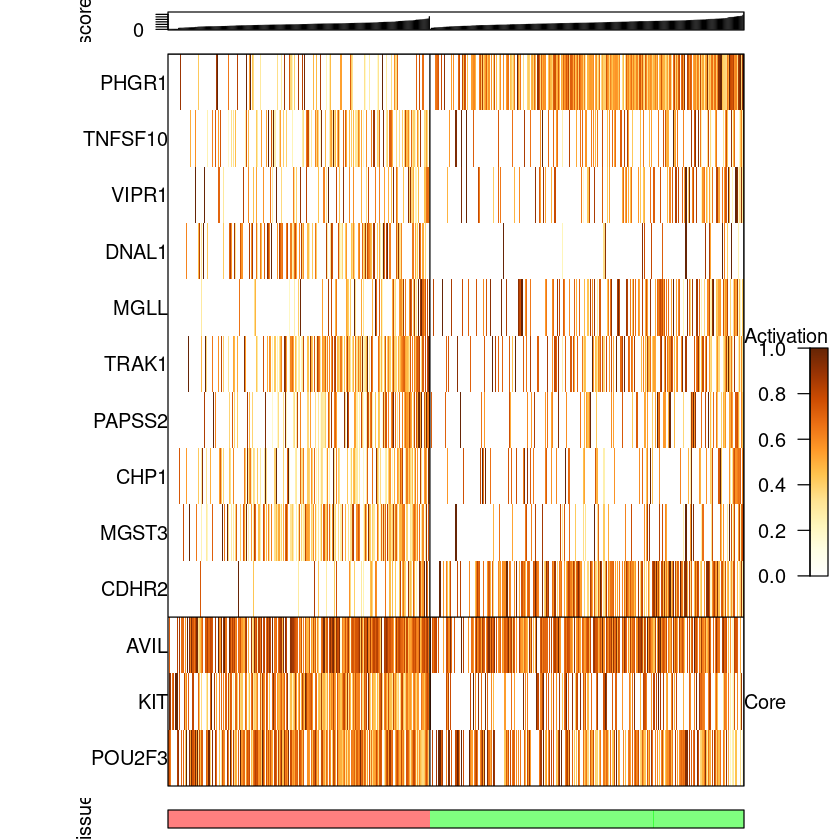

In [51]:

grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
p = function() { 
    par(mar = c(0.5,7,0.5,0.5), fig = c(0,0.9,0.05,0.95))
    image.2(IM3, col = grad, annotate = "rows",
        vct = vct[ colnames(IM3)], hct = hct[ rownames(IM3)])
    box()
    par(fig = c(0,0.9,0,0.05), new = T)
    image(matrix(seq_len(ncol(IM3))), axes = F, 
          col = rainbow(3, alpha = 0.5)[ as.numeric(tissue[ colnames(IM3)])], ylab = "tissue")
    box()
    par(fig = c(0,0.9,0.95,1), new = T)
    plot(score4[ colnames(IM3)], type = "h", xaxs = "i", axes = F, ylab = "score"); axis(2, las = 2)
    box()
    par(fig = c(0.95,1,0.3,0.6), new=T, mar = c(0.5,0.5,0.5,0.5))
    image(y = seq(min(IM3), max(IM3), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2); box()
}

p()
pdf(paste0(outdir, "/ExtFig4l.pdf"), height=8, width=8)
p()
dev.off()


In [52]:
c = "Ileum@adult@CD117+"
genes = c("MGLL", "VIPR1", "SDCBP2", "KRT20", "PHGR1", "VIPR1-AS1")

In [53]:
set.seed(1112)
ds = .downsamp(us, 1000)
c = "Ileum@adult@CD117+"
cells = intersect(no_cc, intersect(colnames(ds), names(comb)[ comb == c]))

In [54]:
bs = 30
skip = 5
n = length(cells)
ss4 = names(sort(score4[cells]))
eyes = seq(1, n - bs, by = skip)
m = list()
for (gene in genes) {
    m[[gene]] = matrix(NA, nrow = length(eyes), ncol = 3)
    for (j in seq_along(eyes)) {
        i = eyes[j]
        sub_cells = ss4[i:(i + bs)]
        m[[gene]][j,] = binconf(sum(ds[gene, sub_cells]), sum(ds[, sub_cells])) * mean(ds[, sub_cells])
    }
    m[[gene]] = m[[gene]] / max(m[[gene]][,1])    
}


png 
  2

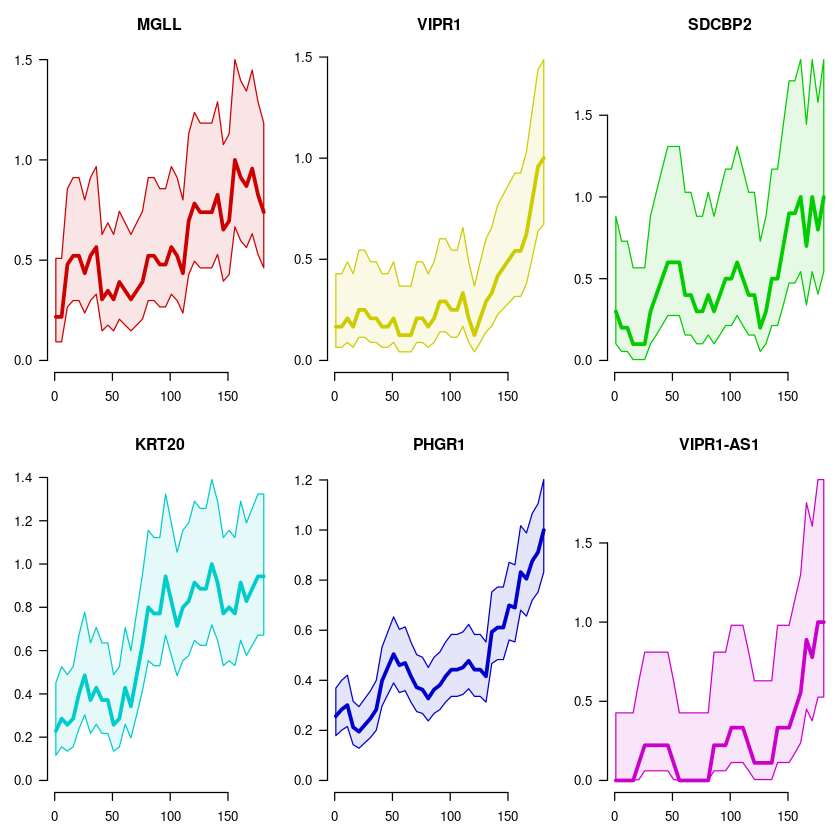

In [55]:
cols = rainbow(length(genes), v = 0.8); names(cols) = genes

p = function() {
    par(mfrow = c(2,3), par(mar = c(3,3,3,0.5)))
    for (gene in genes) {
        plot(eyes, eyes, type = "n", axes = F, xlab = "", ylab = "", ylim = c(0,max(m[[gene]], na.rm=T)), main = gene)
        axis(1); axis(2, las = 2)
        coords = cbind(x = c(eyes, rev(eyes)), y = c(m[[gene]][,2], rev(m[[gene]][,3])))
        polygon(coords, col = alpha(cols[gene], 0.1), border = cols[gene])
        lines(eyes, m[[gene]][,1], col = cols[gene], lwd = 3)    
    }

}

p()
pdf(paste0(outdir, "/ExtFig4m.pdf"), height=4, width = 6)
p()
dev.off()

In [56]:
l = c('Colon@adult@CD117+', 'Ileum@adult@CD117+')
cells = names(comb)[ comb %in% l]

In [57]:
cc_fac = factor(comb2[ cells], levels = paste0(rep(l, each = 3), "@", rep(c("None", "Tuft-3", NA), 2)))
names(cc_fac) = cells

png 
  2

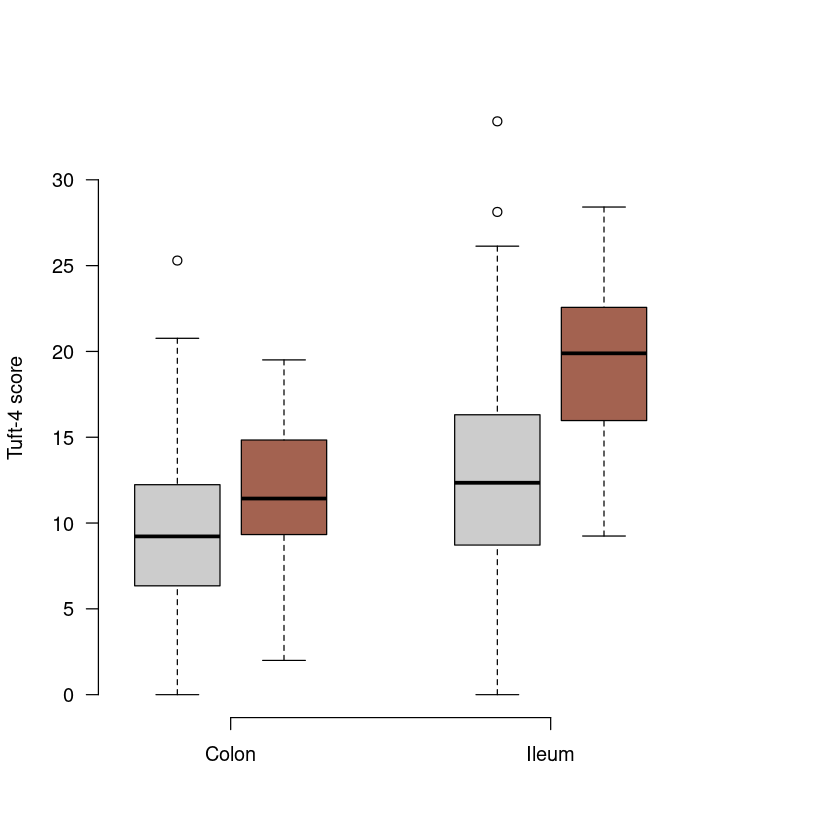

In [58]:

p = function() {
    boxplot(score4[cells] ~ cc_fac[ cells], axes = F, col = c("gray80", cc_col, NA), xlab = "", ylab = "Tuft-4 score")
    axis(2, las = 2); axis(1, at = c(1.5, 4.5), labels = c("Colon", "Ileum"));
}

p()
pdf(paste0(outdir, "/ExtFig4n.pdf"), useDingbats = F)
p()
dev.off()

## Core score over primary

In [59]:
scdb_init("saved_work", force=T)
sc_mat = scdb_mat("tuft_all")

initializing scdb to saved_work


In [60]:
cell_stats = sc_mat@cell_metadata[ sc_mat@cells,]
head(cell_stats)

,amp_batch_id,cell_barcode,umicount,mt_count,coord,source,type,gating,treatment,age,clover
HUB.JO.s037_AAACAGGC,HUB.JO.s037,AAACAGGC,7296,1280,H18,Ileum,organoid,AVIL-Clover+,no_cyto,adult,AVIL
HUB.JO.s037_AAAGCGGA,HUB.JO.s037,AAAGCGGA,3461,626,P12,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AAAGGCTG,HUB.JO.s037,AAAGGCTG,4062,1019,O10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACACGCA,HUB.JO.s037,AACACGCA,8352,1471,L20,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACATGGG,HUB.JO.s037,AACATGGG,4986,692,P10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACCCAAC,HUB.JO.s037,AACCCAAC,8453,1449,O15,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL


In [61]:
colon_cells = rownames(cell_stats)[ cell_stats$gating == "CD117+" & cell_stats$type == "tissue" &
                                  cell_stats$source %in% c("Colon", "Ileum") & 
                                  cell_stats$umicount > 500 & cell_stats$mt_count / cell_stats$umicount < 0.4]
colon_umis = read_large_umis("tuft_all", cells = colon_cells)


In [62]:
X = obj@assays$RNA
data = X[,samp_cells]
data_n = sweep(data,2,colSums(data),"/") * 1000


In [63]:
shared = intersect(rownames(colon_umis), rownames(data))
markers = setdiff(intersect(shared, names(scdb_gset("Elmentaite")@gene_set)), c("MALAT1", "B2M"))
length(shared)

[1] 26595

In [64]:
shared_umis = as.matrix(cbind(data[shared,], colon_umis[shared,]))
anno_l = names(table(anno[ colnames(data_n)]))
anno_n = as.numeric(factor(anno[ colnames(data_n)])); names(anno_n) = colnames(data_n)

In [65]:
colon_n = sweep(colon_umis, 2, colSums(colon_umis), "/") * 1000
foc = log(1 + 7 * colon_n)

In [66]:
core_genes = intersect(rownames(shared_umis), rownames(tuft_genes)[ tuft_genes$anno == "Core"])

In [67]:
shared_n = cbind(data_n[ shared,], colon_n[shared,])
foc = log(1 + 7 * shared_n)

In [68]:
score = colSums(foc[ core_genes,])


In [69]:
cell_anno = factor(ifelse(colnames(shared_umis) %in% colon_cells, cell_stats[ colnames(shared_umis), "source"], anno_l[anno[ colnames(shared_umis)]]),
                   levels = c(anno_l, "Ileum", "Colon"))
names(cell_anno) = colnames(shared_umis)

In [70]:
thresh=49

png 
  2

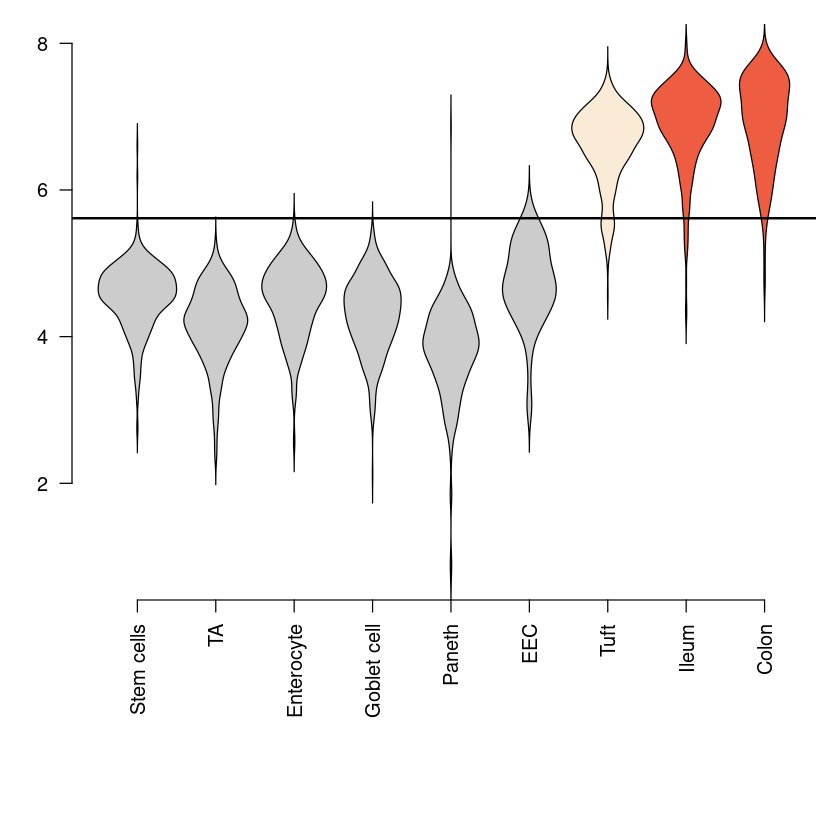

In [71]:
sub_cells = intersect(names(which(!is.na(cell_anno))), colnames(shared_umis))

p = function() {
    par(mar = c(10,3,1,1))
    plot_density_points(log2(score[sub_cells]), cell_anno[sub_cells], with_box = F, las = 2, grid = F, with_points = F, 
                        pol.col = c(rep("gray80", 6), "antiquewhite", rep("tomato2", 2))) #,
                       #inflate=0.6); 
    abline(h=log2(thresh), lwd = 2)
}

p()
pdf(paste0(outdir, "/ExtFig3j.pdf"), useDingbats = F)
p()
dev.off()

## Analyze Hickey's paper

In [72]:
id = "hickey_tuft"
sc_mat = scdb_mat(id)

In [73]:
cell_stats = sc_mat@cell_metadata[ sc_mat@cells,]

In [74]:
cell_stats$patient = vecsplit(cell_stats$folder, "-", 1)

In [75]:
hickey_tuft_cells = rownames(cell_stats)[cell_stats$CellType == "Tuft" & cell_stats$tissue == "Jejunum"]

In [76]:
hickey_umis = read_large_umis(id, cells = hickey_tuft_cells)
hickey_n = sweep(hickey_umis, 2, colSums(hickey_umis), "/") * 1000
foc = log(1 + 7 * hickey_n)

In [77]:
tuft_cells = names(anno)[ !is.na(anno) & anno == "Tuft" & metadata$Age_group == "Adult"]
tuft_umis = obj@assays$RNA[, tuft_cells]

shared_genes = intersect(rownames(tuft_umis), rownames(hickey_umis))

shared_umis = cbind(tuft_umis[ shared_genes, ], hickey_umis[ shared_genes,])

In [78]:
comb = ifelse(colnames(shared_umis) %in% hickey_tuft_cells, "Hickey", "Teichman"); names(comb) = colnames(shared_umis)
med_uc = tapply(colSums(shared_umis), comb, median)

In [79]:
shared_n = sweep(shared_umis, 2, colSums(shared_umis), "/") * 1000
shared_foc = log(1 + 7 * shared_n)

In [80]:
shared_top_genes = setdiff(intersect(rownames(shared_umis), rownames(tuft_genes)), c())
modules = t(apply(shared_foc[ shared_top_genes,], 2, tapply, tuft_genes[ shared_top_genes, "anno"], sum))


In [81]:
teichman_pat = as.vector(metadata[ tuft_cells, "Sample.name"]); names(teichman_pat) = tuft_cells

hickey_pat = as.vector(cell_stats[ colnames(hickey_umis), "patient"]); names(hickey_pat) = colnames(hickey_umis)


In [82]:
good_te_pats = names(which(table(teichman_pat) > 20))
good_te_cells = names(teichman_pat)[ teichman_pat %in% good_te_pats]


In [83]:
good_hi_pats = names(which(table(hickey_pat) > 20))
good_hi_cells = names(hickey_pat)[ hickey_pat %in% good_hi_pats]


In [84]:
cc_genes = read.table("release_import/for_figures/cc_genes.txt", stringsAsFactors = F, h=T)[[1]]


In [85]:
cc_umis = colSums(shared_foc[ cc_genes,])

png 
  2

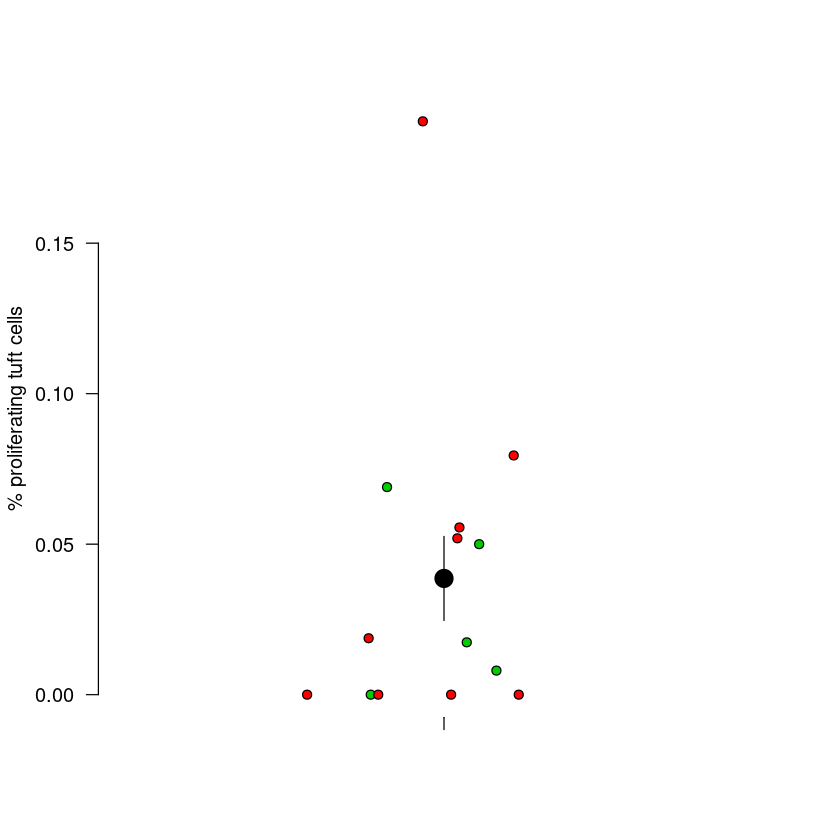

In [86]:
X = rbind(table(teichman_pat[ good_te_cells], log2(cc_umis[ good_te_cells]) > 3),
table(hickey_pat[ good_hi_cells], log2(cc_umis[ good_hi_cells]) > 3.5))
cc_freq = (X / rowSums(X))[,2]

cc_mean = mean(cc_freq)
cc_err = std.error(cc_freq)

p = function() {
    plot(runif(length(cc_freq), -0.2, 0.2), cc_freq, pch = 21, bg = 2 + (names(cc_freq) %in% good_te_pats), xlim = c(-0.5,0.5), axes = F,
        xlab = "", ylab = "% proliferating tuft cells", xaxs = "i")
    segments(0, cc_mean - cc_err, y1 = cc_mean + cc_err)
    points(0, cc_mean, pch = 20, cex = 3)
    axis(2, las = 2); axis(1, at = 0, labels = "")

}

p()
pdf(paste0(outdir, "/ExtFig4k.pdf"), height=6, width=2, useDingbats = F)
p()
dev.off()


## Fetal

table(anno[ samp_cells])

eec_pops = names(table(metadata$Integrated_05))[12:21]
anno = as.vector(metadata$Integrated_05)
names(anno) = rownames(metadata)
anno[ anno %in% eec_pops] = "EEC"
table(metadata$annotation,anno)

In [87]:
good_cells = names(anno)[ anno == "Tuft" &
                        metadata$Age_group %in% c("Adult", "First trim", "Second trim", "Pediatric")]
age = as.vector(metadata$Age_group); names(age) = rownames(metadata)
x = table(age[ good_cells])


In [88]:
good_cells = names(which(!is.na(age[ good_cells])))


In [89]:
good_pops = names(which(x > 30))
anno = factor(age, levels = c("Second trim", "Pediatric", "Adult")); names(anno) = rownames(metadata)

In [90]:

samp_cells = good_cells 

In [91]:
X = obj@assays$RNA
data = X[,samp_cells]
data_n = sweep(data,2,colSums(data),"/") * 1000

In [92]:

adult_cells = rownames(metadata)[ metadata$Diagnosis == "Healthy adult"]


In [93]:
scdb_init("saved_work", force=T)

sc_mat = scdb_mat("tuft_all")
cell_stats = sc_mat@cell_metadata
head(cell_stats)

initializing scdb to saved_work


,amp_batch_id,cell_barcode,umicount,mt_count,coord,source,type,gating,treatment,age,clover
HUB.JO.s037_AAACAGGC,HUB.JO.s037,AAACAGGC,7296,1280,H18,Ileum,organoid,AVIL-Clover+,no_cyto,adult,AVIL
HUB.JO.s037_AAAGCGGA,HUB.JO.s037,AAAGCGGA,3461,626,P12,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AAAGGCTG,HUB.JO.s037,AAAGGCTG,4062,1019,O10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACACGCA,HUB.JO.s037,AACACGCA,8352,1471,L20,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACATGGG,HUB.JO.s037,AACATGGG,4986,692,P10,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL
HUB.JO.s037_AACCCAAC,HUB.JO.s037,AACCCAAC,8453,1449,O15,Ileum,organoid,AVIL-Clover+,IL4+IL13,adult,AVIL


In [94]:

fetal_cells = rownames(cell_stats)[ cell_stats$age == "fetal" & cell_stats$type == "tissue" & cell_stats$gating == "CD117+" &
                    cell_stats$umicount > 500 &
                    cell_stats$mt_count / cell_stats$umicount < 0.4]

In [95]:
fetal_umis = read_large_umis("tuft_all", cells = fetal_cells)

In [96]:
shared_genes = intersect(rownames(data), rownames(fetal_umis))
shared_umis = cbind(data_n[ shared_genes,], fetal_umis[ shared_genes,])

In [97]:
anno_l = names(table(anno))
cell_anno = factor(ifelse(colnames(shared_umis) %in% fetal_cells, "KIT", anno_l[anno[ colnames(shared_umis)]]),
                   levels = c(anno_l, "KIT"))

names(cell_anno) = colnames(shared_umis)


In [98]:
shared_n = sweep(shared_umis, 2, colSums(shared_umis), "/") * 1000
foc = log(1 + 7 * shared_n)

In [99]:
core_genes = intersect(rownames(shared_umis), rownames(tuft_genes)[ tuft_genes$anno == "Core"])

In [100]:
score = colSums(foc[ core_genes,])

png 
  2

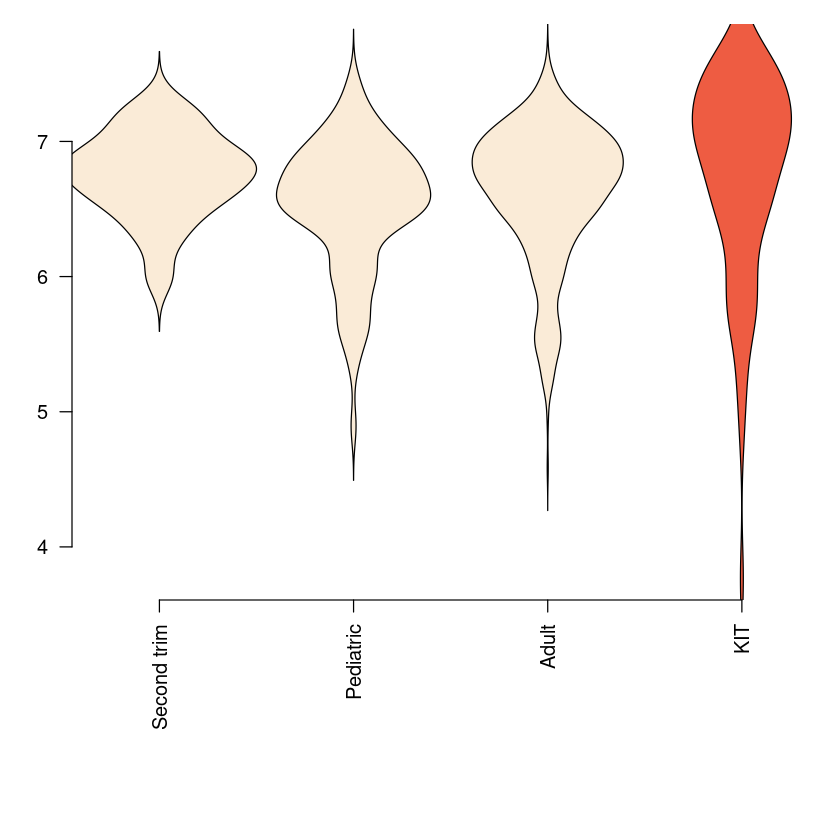

In [101]:
p = function() {
    par(mar = c(10,3,1,1))
    plot_density_points(log2(score), cell_anno, with_box = F, las = 2, grid = F, with_points = F, 
        pol.col = c(rep("antiquewhite", 3), "tomato2")) #,

}

p()
pdf(paste0(outdir, "/FigS9b.pdf"), useDingbats = F)
p()
dev.off()

png 
  2

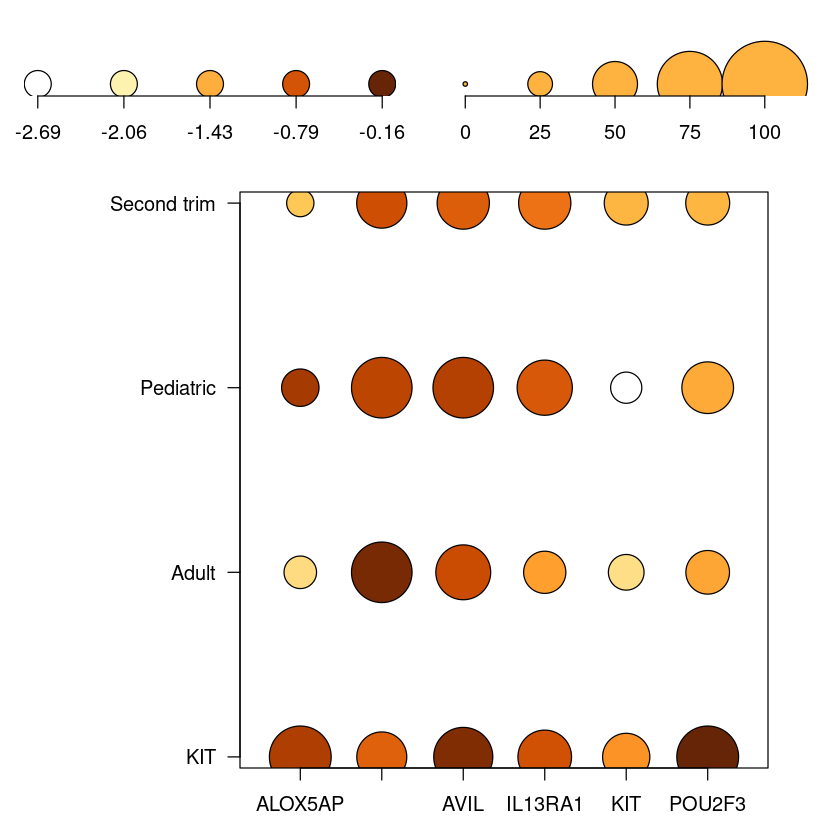

png 
  2

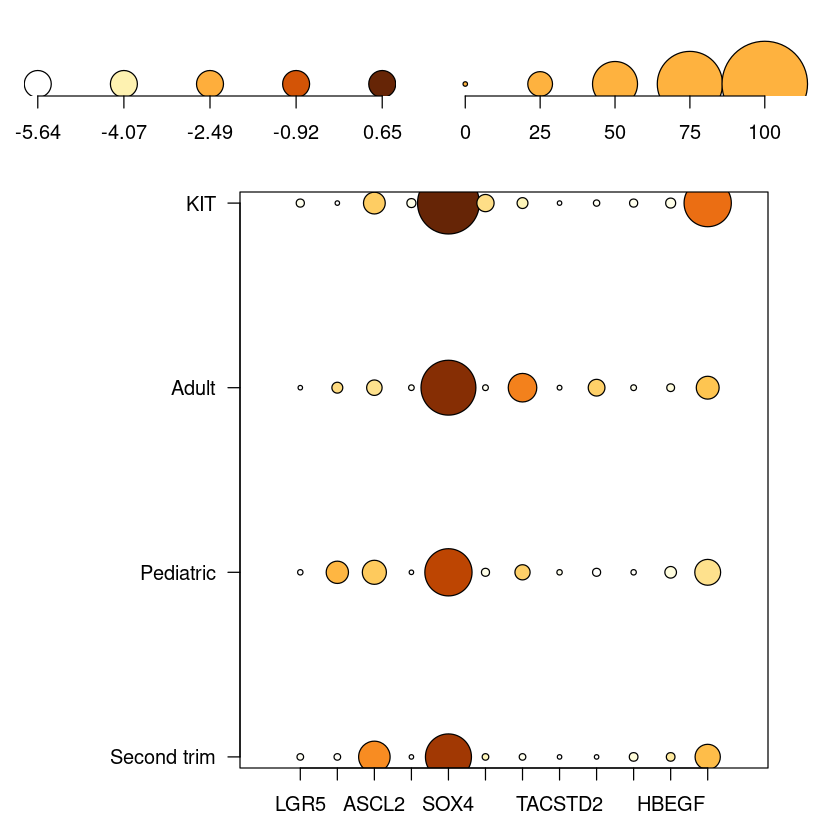

In [102]:


genes = c("ALOX5AP", "BMX", "AVIL", "IL13RA1", "KIT", "POU2F3")
m = t(apply(shared_n[genes, ], 1, tapply, cell_anno, mean))
IM = log2(m[, rev(colnames(m))] + 0.02)
exp_freq = t(apply(shared_umis[genes, ] > 0, 1, tapply, cell_anno, mean)) * 100
exp_freq = exp_freq[ ,colnames(IM)]

grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)

p = function() {
    par(mar = c(3,10,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}

p()
pdf(paste0(outdir, "/ExtFig9c.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

genes = union(read.table("release_import/for_figures/stem_genes.txt", stringsAsFactors = F)[[1]],
              c("MEX3A", "ANXA1", "TACSTD2", "PROX1"))

m = t(apply(shared_n[genes, ], 1, tapply, cell_anno, mean))
IM = log2(m + 0.02)
exp_freq = t(apply(shared_umis[genes, ] > 0, 1, tapply, cell_anno, mean)) * 100
exp_freq = exp_freq[ ,colnames(m)]

p()
pdf(paste0(outdir, "/ExtFig9d.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()
